<a href="https://colab.research.google.com/github/hbbell333/Mechanistic-Interpretability/blob/main/AIPI_590_Mechanistic_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

**Data Generation**

The task I'm using for this project is mirroring binary sequences, so we'll need to generate a dataset where X are short binary sequences, their labels are the mirrored versions.

In [ ]:
def generate_mirrored_seq_data(n_samples=10000, seq_length=8):

  X = []
  y = []

  for _ in range(n_samples):
      binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
      label = binary_str[::-1]
      X.append(binary_str)
      y.append(label)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_mirrored_seq_data(2000, seq_length)
X_val, y_val = generate_mirrored_seq_data(500, seq_length)


Now we'll train a simple MLP on our task. We'll use a single internal fully connected layer, and an additional fully connected output layer.

In [ ]:
# Code adapted from the starter notebook. Gemini used to debug after changing loss to cross entropy -- uses cited in comments.

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SequenceReversalMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim) # Output full mirrored sequence

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # for interpretability

#create model instance
model = SequenceReversalMLP(input_dim=seq_length, hidden_dim=10, output_dim=seq_length * 2)
print(model)

#flatten labels
# GEMINI: Used Gemini to debug error with y format. 11/8
y_train_flat = y_train.view(-1)
y_val_flat = y_val.view(-1)

# Training loop with Cross-Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # Update to cross entropy loss

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    # GEMINI: Used Gemini to update training loop for multi-class classification task 11/8
    # Just reformatted outputs to work with crossentropy loss
    #Reshape output for CrossEntropyLoss: (batch_size * seq_length, num_classes)
    out_flat = out.view(-1, 2)

    loss = criterion(out_flat, y_train_flat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Accuracy for each position
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    # GEMINI: Used Gemini to update eval to work for sequence reversal (from regression) on 11/8
    # Reshape predictions: (batch_size * seq_length, num_classes)
    preds_flat = preds.view(-1, 2)
    predicted_classes = torch.argmax(preds_flat, dim=1)

    correct_predictions = (predicted_classes == y_val_flat).float()
    accuracy = correct_predictions.mean().item()

print(f"Validation Accuracy: {accuracy:.2f}")

SequenceReversalMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=16, bias=True)
)
Final training loss: 0.06211734190583229
Validation Accuracy: 1.00


**Print Activations of Sample Input**

As a preliminary check we can print the activations of the hidden layer on a sample input.

In [ ]:
def print_activations(sample_input):
  with torch.no_grad():
      logits, hidden = model(sample_input)

  print(f"Sample Input: {np.round(sample_input.tolist(), 2)}")
  print(f"Hidden Activations: {np.round(hidden.tolist(), 2)}")
  print(f"Output Logits: {np.round(logits.tolist(),2)}")


  # Reshape outputs & argmax
  predicted_classes = torch.argmax(logits.view(1, seq_length, 2), dim=2)

  print(f"Predicted Classes: {predicted_classes}")


sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
print_activations(sample_input)


Sample Input: [[1. 0. 1. 0. 1. 1. 0. 0.]]
Hidden Activations: [[0.92 1.47 1.98 0.   2.22 2.61 0.99 0.88 0.6  1.09]]
Output Logits: [[ 2.83 -3.2   0.69 -0.08 -1.49  1.91 -2.01  0.69  1.97 -1.4   0.25  1.22
  -0.48 -0.43 -0.84  0.23]]
Predicted Classes: tensor([[0, 0, 1, 1, 0, 1, 1, 1]])


The first thing I notice about the hidden layer here is that only 8 neurons are receiving much activation, which coincides with the input sequence length. Based on this, it seems likely that each neuron is responsible for a single bit of the input sequence.

**Neuron Ablation**

One way to further investigate this hypothesis is to selectively turn neurons off, and see how it impacts the output of the model.

In [ ]:
# Modified from starter notebook

# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_mirror = torch.flip(test_input, dims=[1])

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, hidden_layer = model(test_input)
    baseline_pred = torch.argmax(baseline_output.view(1, seq_length, 2), dim=2)

hidden_dim = len(hidden_layer[0])

print(f"True mirror: {true_mirror}")
print(f"Baseline prediction: {baseline_pred}\n\n")


def ablate_neuron(neuron_to_zero):
  # Manually run forward pass with neuron ablated
  with torch.no_grad():
      h = F.relu(model.fc1(test_input))
      h[:, neuron_to_zero] = 0  # zeroing neuron
      modified_output = model.fc2(h)
      modified_pred = torch.argmax(modified_output.view(1, seq_length, 2), dim=2)




  print(f"**Neuron {neuron_to_zero} zeroed**\n")
  print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred}")

  diff_mask = torch.zeros(8)

  if(torch.equal(baseline_pred, modified_pred)):
    print("\nNo change detected\n")
  else:
    diff_mask = (baseline_pred != modified_pred).float().int() # Convert boolean to 0s and 1s
    print(f'Baseline and modified differ at positions: {diff_mask}\n')
  return(modified_pred, diff_mask)



for i in range(hidden_dim):
  # Zero out one neuron in the hidden layer (e.g., neuron 3)
  ablate_neuron(i)

True mirror: tensor([[0., 1., 0., 0., 1., 1., 0., 1.]])
Baseline prediction: tensor([[0, 1, 0, 0, 1, 1, 0, 1]])


**Neuron 0 zeroed**

Prediction (with neuron 0 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 1 zeroed**

Prediction (with neuron 1 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 2 zeroed**

Prediction (with neuron 2 zeroed): tensor([[0, 1, 0, 0, 0, 0, 0, 0]])
Baseline and modified differ at positions: tensor([[0, 0, 0, 0, 1, 1, 0, 1]], dtype=torch.int32)

**Neuron 3 zeroed**

Prediction (with neuron 3 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 4 zeroed**

Prediction (with neuron 4 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 5 zeroed**

Prediction (with neuron 5 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 6 zeroed**

Prediction (with neuron 6 zeroed): tensor([[0, 1, 0, 0, 1, 1, 0, 1]])

No change detected

**Neuron 7 zeroed**

Pred

Interestingly, we can see that for this particular example, the prediction is only impact when we zero out two of the neurons (3 and 7). The two neurons that had very low activation in the earlier example (2 and 6) did not impact the output when zeroed, which makes sense. I am surprised to see that of the other 8 neurons, only two of them change the output when zeroed.

One possibility is that the network encodes the mirrored sequence with some redundancy, so that when one neuron is lost it can still often reconstruct the sequence. Alternatively, this behavior could be due to the structure of this specific input the standard encoding of the network actually zeroed out some of the neurons on it's own. Let's check this second possibility by re-using the earlier function to display hidden layer activations.


In [ ]:
#use same test_input from cell above
print_activations(test_input)

Sample Input: [[1. 0. 1. 1. 0. 0. 1. 0.]]
Hidden Activations: [[1.18 2.23 3.86 0.   0.   1.06 1.65 1.05 0.93 0.53]]
Output Logits: [[ 2.71 -1.85 -2.89  3.49  2.46 -1.8   1.97 -2.51 -2.03  2.75 -2.15  2.63
   0.42 -2.51 -2.23  2.08]]
Predicted Classes: tensor([[0, 1, 0, 0, 1, 1, 0, 1]])


Inspecting the hidden activations output, we can see that the important neurons where in fact more activated than the others (3, and 3.42, respectively).

**Visualizing one-hot activations**

Since it seems like certain neurons may be responsible for representing specific patterns within the input sequences, let's start by visualizing the neuron activations across 8 one-hot sequences.

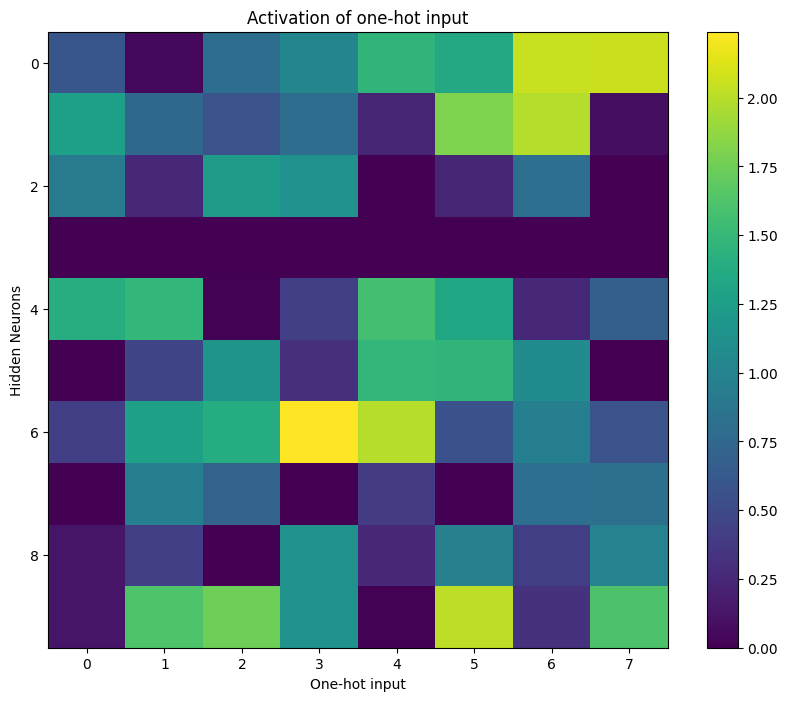

In [ ]:
activations_out = []

for i in range(seq_length):
  one_hot = torch.zeros(1, seq_length)
  one_hot[0, i] = 1

  with torch.no_grad():
      logits, hidden = model(one_hot)
  activations = np.round(hidden.tolist(), 2)
  activations_out.append(activations[0])

# Gemini used to debug plotting code 11/8. Converted list to np array and transposed.
plt.figure(figsize=(10, 8))
activations_np = np.array(activations_out).T # Convert list to numpy array and transpose
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("One-hot input")
plt.ylabel("Hidden Neurons")
plt.title("Activation of one-hot input")
plt.colorbar()
plt.show()

**Analysis**


Based on the figure above, it does not seem that neurons are mapping directly to input values. If this were the case, we would expect to see a single highly active neuron for each of the one-hot input sequences. Instead, we see that the 0 and 1st neurons are the most highly active across multiple inputs, and that most of the neurons have some activation in some inputs but without a descernable pattern.

Since we can't find any descernable pattern of activations in the one-hot sequences, let's visualize some sequence patterns that the network may be picking up on such as alternating values, half & half values, or all 1's.

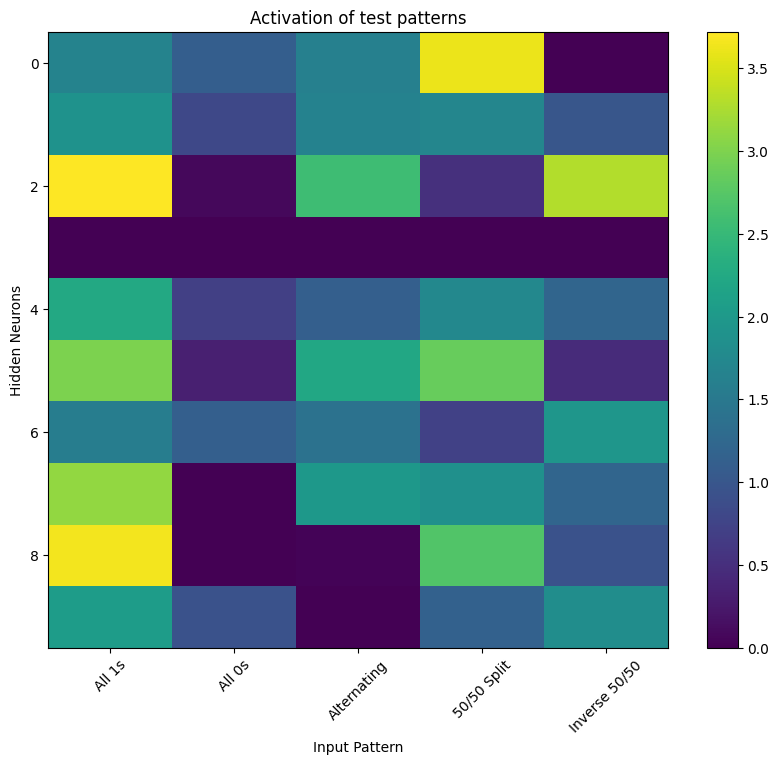

In [ ]:
test_patterns = []

#let's try all 1s
test_patterns.append([1, 1, 1, 1, 1, 1, 1, 1])

#all 0s
test_patterns.append([0, 0, 0, 0, 0, 0, 0, 0])

#alternating values
test_patterns.append([1, 0, 1, 0, 1, 0, 1, 0])

#50/50 split
test_patterns.append([0, 0, 0, 0, 1, 1, 1, 1])

#And the reversed version of split
test_patterns.append([1, 1, 1, 1, 0, 0, 0, 0])

# Clear the list before appending new activations
activations_out = []

for array in test_patterns:

  array = torch.tensor(array, dtype=torch.float32).unsqueeze(0) # Convert to float32 and add batch dimension

  with torch.no_grad():
      logits, hidden = model(array)
  activations = np.round(hidden.tolist(), 2)
  activations_out.append(activations[0])

# Create labels for the x-axis
x_labels = ["All 1s", "All 0s", "Alternating", "50/50 Split", "Inverse 50/50"]


# Gemini used to debug plotting code 11/8. Converted list to np array and transposed.
plt.figure(figsize=(10, 8))
activations_np = np.array(activations_out).T # Convert list to numpy array and transpose
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Input Pattern")
plt.ylabel("Hidden Neurons")
plt.title("Activation of test patterns")
plt.colorbar()
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
plt.show()

**Analysis**

We can see that neuron **3 never received basically any activation**. I didn't notice this in the first visualization, but looking back it was the case there too. This suggests that model had more capacity than necessary to fully learn the task, so this neuron is just not being utilized (at least not in any of the cases we've tested here).

Interestingly, all 0s has lower activation across the board, so the **model responds to 1s more than 0s**. This is somewhat unexpected for this task, since 1s and 0s are effectively the same (in that both need to be mirrored). Given the task, I would expect the neurons to be very location dependent, however based on the visualization here, as well as the one-hot visualization above, this does not seem to be the case (or at least, not the only thing that is going on in the model).

If we compare between the 'all 1s' pattern and the two '50/50 split' patterns, it appears that neurons 2 and 8 activate based on the amount of 1's in the first or second half of the sequence, respectively. Looking closer at the activations in the 'alternating' pattern, neuron 8 doesn't activate at all, and neuron 2 receives only mild activation. This suggests that **these neurons activate only when their respective half of the sequence is highly positive** (i.e., the neuron activates don't scale linearly with the proportion of 1's in the sequence, but rather activate in more of an 'all or nothing' fasion)

The activations between 50/50 and inverse 50/50 were basically flipped (i.e., high activation in 50/50 -> low activation in inverse 50/50). This suggests that **the model does respond to patterns in the input**.

**Reflection**

I was surprised to see how difficult to interpret this model was, even though it is small and trained on a relatively simple task.

Some takeaways from the mechanistic interpretability methods:


1.   The model is somewhat resistant to zeroing out individual neurons
2.   The model doesn't use all of the neurons available. Neuron 3 was received no activation in our experiments. This suggests that the model was able to fully learn the task with only 9 neurons.
3.  The one-hot visualization suggests that the model does not rely solely on the positions of 1s and 0s.
4.  The model focuses more on 1s than 0s.
5.  The model seems to use patterns in the input sequences.

**Further exploration**
One direction for further exploration would be to look more closely at some simple test cases to build a better theory for how the model makes individual predictions.

I tried to do this with the one-hot visualizations, but one issue with my approach was that I ordered the neurons based on their arbitrary numbering. It seems very possible that the network learned a more disordered mapping from 1s in the input sequence to neuron activations. Possibly correlating neuron activations to 1s in input sequences across a larger sample of inputs could yield better insights into the underlying processes happening within the model.

